<h1 style="text-align: center;">Analyis of Point Production of NBA Players</h1>

# Introduction

Using this dataset of NBA player stats we want to perform a regression analysis of the selected variables to help predict the on-court performance of a player (their average points scored). To do so, all non-preformance related stats, including, age,  height, weight, and draft pick will be used. The season variable will also allow player preformances to be measured throughout time and compare NBA starts from all eras and styles of the game. All of these factors were selected because of their likelihood to correlate with stronger on-court performance.

Our question: How do our selected factors help to predict the individual performance of NBA players? 

To do this, we will use [this dataset](https://www.kaggle.com/datasets/justinas/nba-players-data) from Kaggle. The data was acquired through the NBA API with missing information supplied by scraping from another NBA source (for this reason, the dataset was taken directly from Kaggle and not the original source). 

# Methods and Results

## Load Libraries

In [7]:
library(tidyverse)
library(tidymodels)
library(repr)
options(repr.matrix.max.rows = 6)

## Dataset Load & Preperation

First we pull our dataset from the internet.

The dataset contains 22 variables, the majority of which we need to discard as being impractical to use, having little impact on player performance (player name) or being directly related to a performance variable. We will conduct analysis on the remaining selected variables to try and predict the average points a player will get per season using regression analysis. By first training a model on the training data for each respective datapoint category we will then be able to analyze the knn regression and decide which of the columns provides the best predictor for a players preformance (net_rating)

In [8]:
url <-"https://raw.githubusercontent.com/mdean808/dsci-100-group-project/b11c50b091b2c4a554a2b7ff8f9e568e081b0f3c/all_seasons.csv"


temp <- tempfile()


download.file(url, temp)
# read the dataset from temp file
player_data <- read_csv(temp)
head(player_data)

New names:
• `` -> `...1`
Rows: 12305 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (8): player_name, team_abbreviation, college, country, draft_year, draf...
dbl (14): ...1, age, player_height, player_weight, gp, pts, reb, ast, net_ra...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,⋯,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,Dennis Rodman,CHI,36,198.12,99.79024,Southeastern Oklahoma State,USA,1986,2,⋯,5.7,16.1,3.1,16.1,0.186,0.323,0.100,0.479,0.113,1996-97
1,Dwayne Schintzius,LAC,28,215.90,117.93392,Florida,USA,1990,1,⋯,2.3,1.5,0.3,12.3,0.078,0.151,0.175,0.430,0.048,1996-97
2,Earl Cureton,TOR,39,205.74,95.25432,Detroit Mercy,USA,1979,3,⋯,0.8,1.0,0.4,-2.1,0.105,0.102,0.103,0.376,0.148,1996-97
3,Ed O'Bannon,DAL,24,203.20,100.69742,UCLA,USA,1995,1,⋯,3.7,2.3,0.6,-8.7,0.060,0.149,0.167,0.399,0.077,1996-97
4,Ed Pinckney,MIA,34,205.74,108.86208,Villanova,USA,1985,1,⋯,2.4,2.4,0.2,-11.2,0.109,0.179,0.127,0.611,0.040,1996-97
5,Eddie Johnson,HOU,38,200.66,97.52228,Illinois,USA,1981,2,⋯,8.2,2.7,1.0,4.1,0.034,0.126,0.220,0.541,0.102,1996-97


For our project, we will focus only on the specific parameters to judge the overall performance of an NBA player, these include but are not limited to points (pts), rebounds (reb), and assists (ast), all key metrics in preformance. 

Note that for `draft_round` players labeled as `Undrafted` were removed. Additionally, players drafted in or before 2000 are excluded, to keep the data used recent.

In [84]:
nba_players <- player_data |>
    filter(draft_year > 2011) |>
    select(net_rating, draft_number, pts, reb, ast, usg_pct, ts_pct) |>
    # remove undrafted players with no draft number "Undrafted"
    filter(draft_number != "Undrafted") |>
    mutate(draft_number = as.numeric(draft_number))            
nba_players

net_rating,draft_number,pts,reb,ast,usg_pct,ts_pct
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.9,28,2.3,1.6,0.3,0.198,0.417
12.1,37,4.0,2.7,0.4,0.146,0.632
-3.7,38,1.3,0.3,0.4,0.199,0.349
⋮,⋮,⋮,⋮,⋮,⋮,⋮
1.2,44,1.9,1.1,0.0,0.247,0.428
-5.3,1,10.8,2.7,5.5,0.265,0.517
9.3,6,12.1,3.8,5.9,0.179,0.540


Now we will split the data into training and testing. We will use the training data to build our regression model and our testing data to test the validity of our model. 

In [85]:
set.seed("1234")
nba_players_split <- initial_split(nba_players, prop = 0.75, strata = pts)
nba_training <- training(nba_players_split)
nba_testing <- testing(nba_players_split)

nba_training

net_rating,draft_number,pts,reb,ast,usg_pct,ts_pct
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-3.7,38,1.3,0.3,0.4,0.199,0.349
-12.3,60,1.3,1.1,0.2,0.134,0.407
-11.6,25,2.6,0.8,1.2,0.213,0.461
⋮,⋮,⋮,⋮,⋮,⋮,⋮
2.0,19,12.1,2.9,1.5,0.189,0.544
3.5,3,28.4,9.1,8.7,0.368,0.571
9.3,6,12.1,3.8,5.9,0.179,0.540


# Dataset Visualization

Now we will look at the correlation of multiple parameters compared with points. This will allow us to predict which parameters strongly influence overall points scored before we build our regression model. 

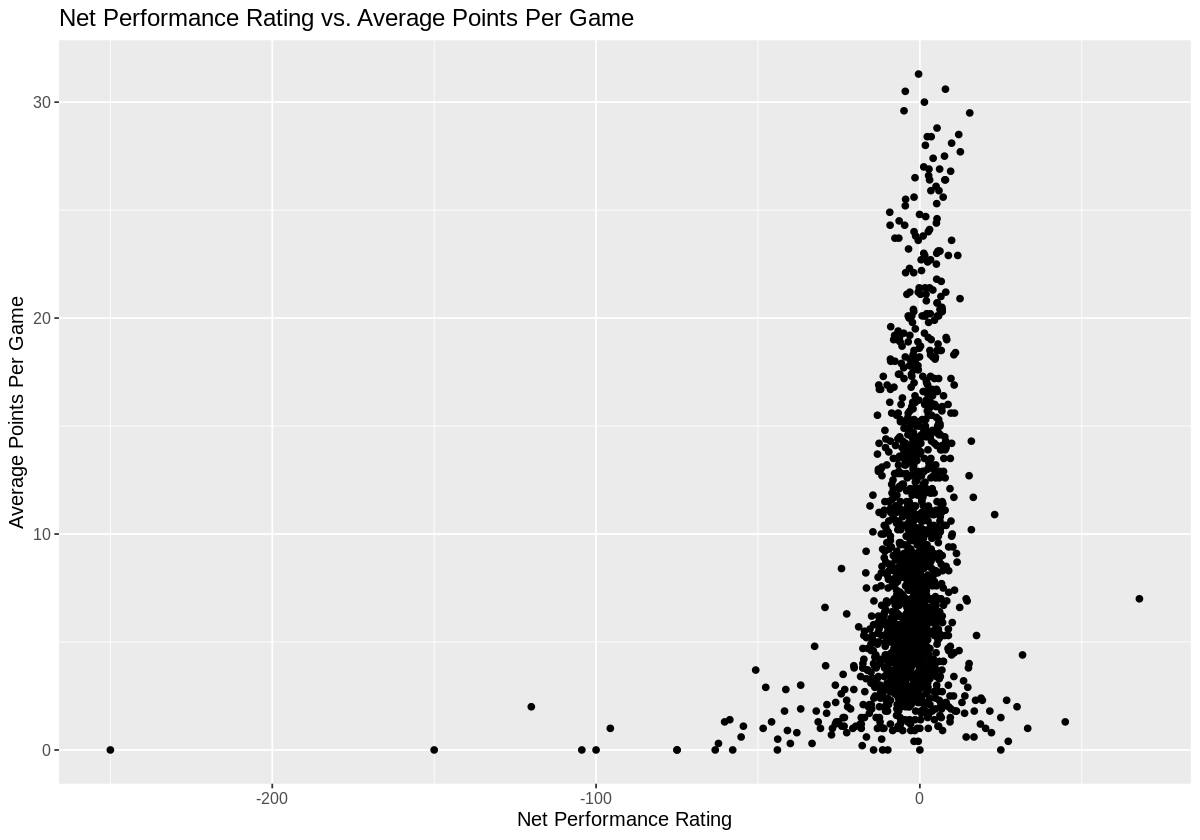

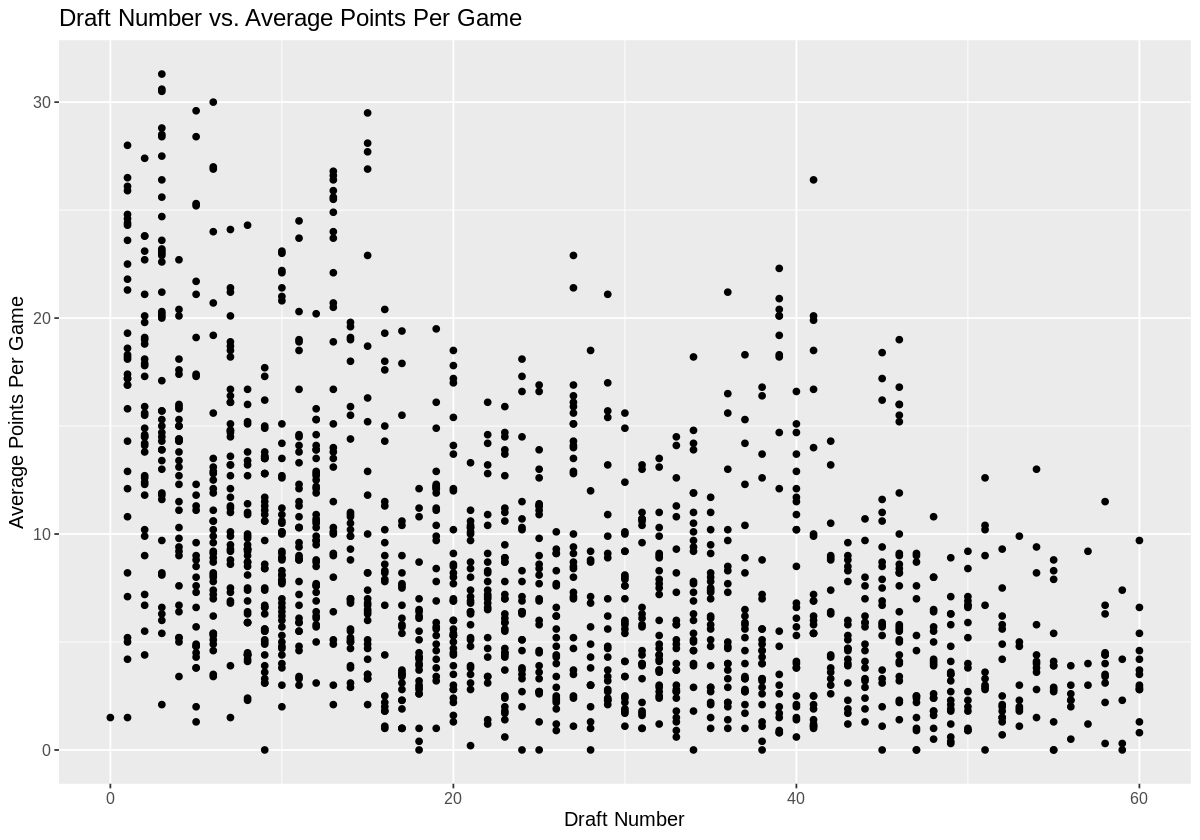

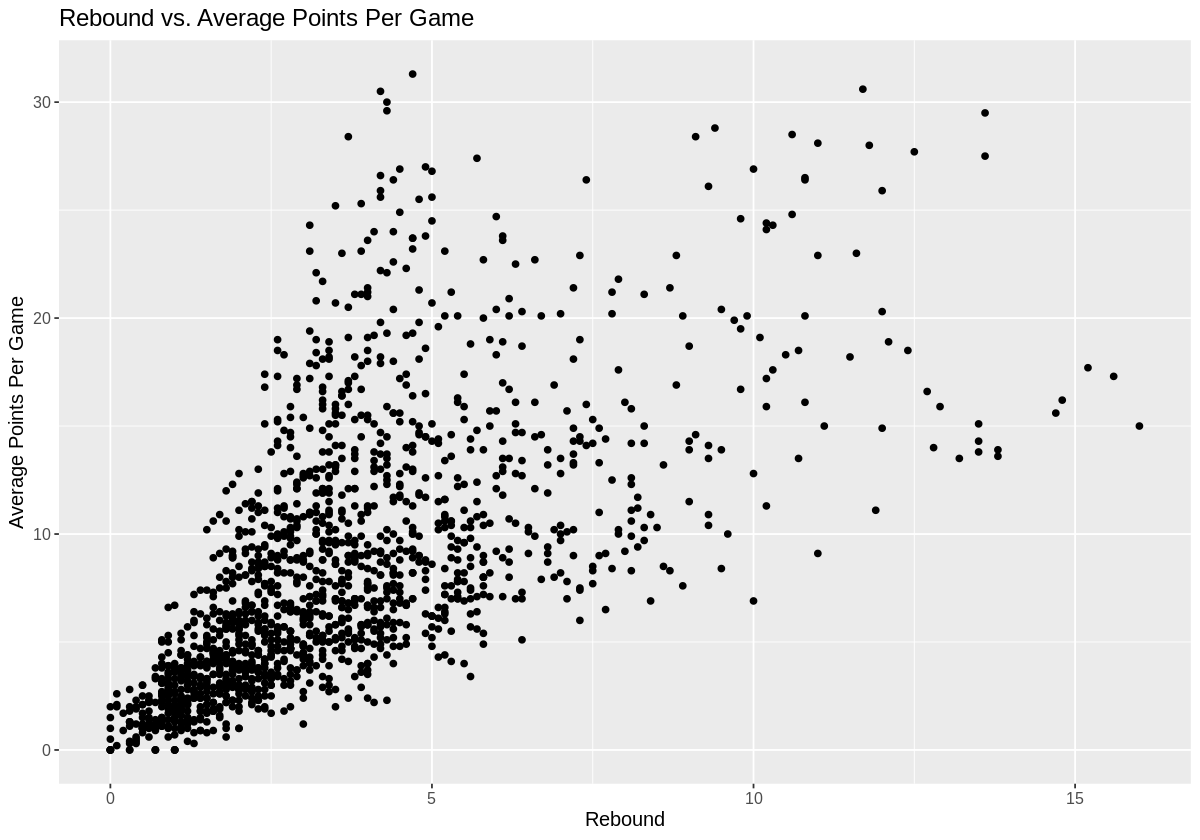

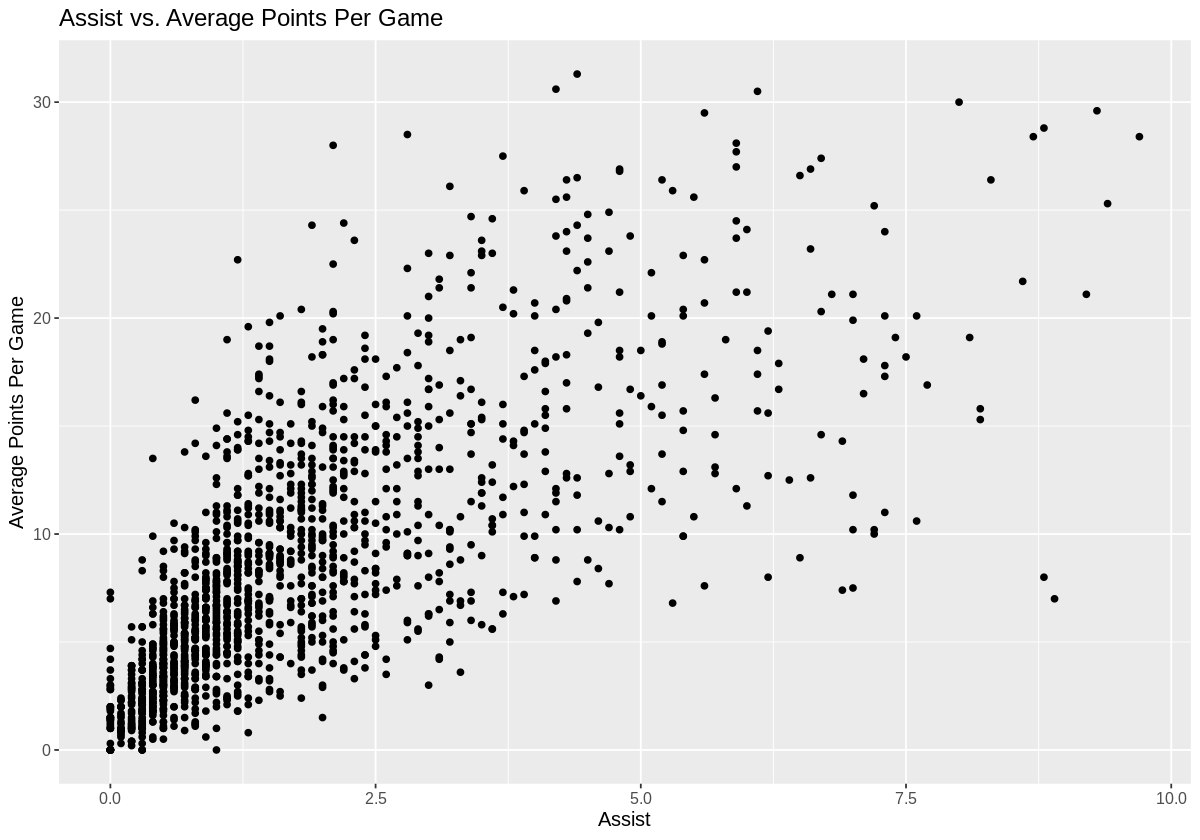

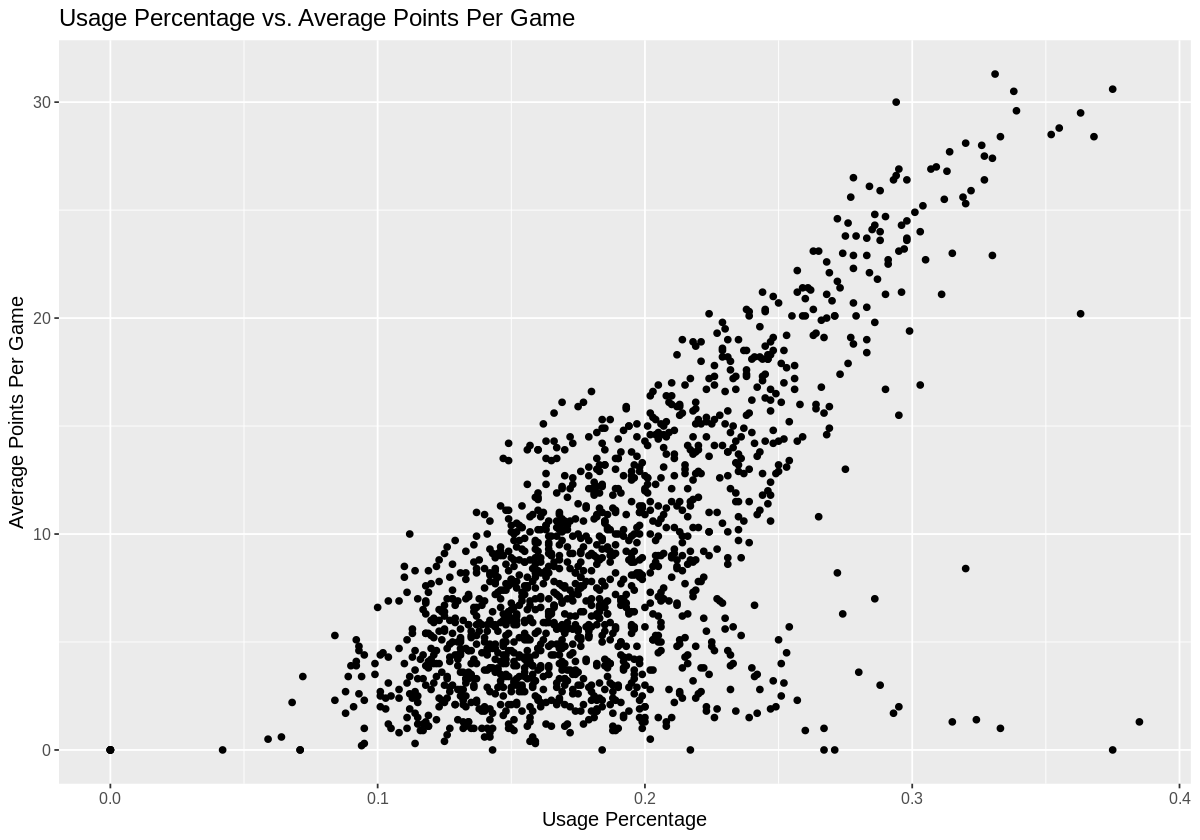

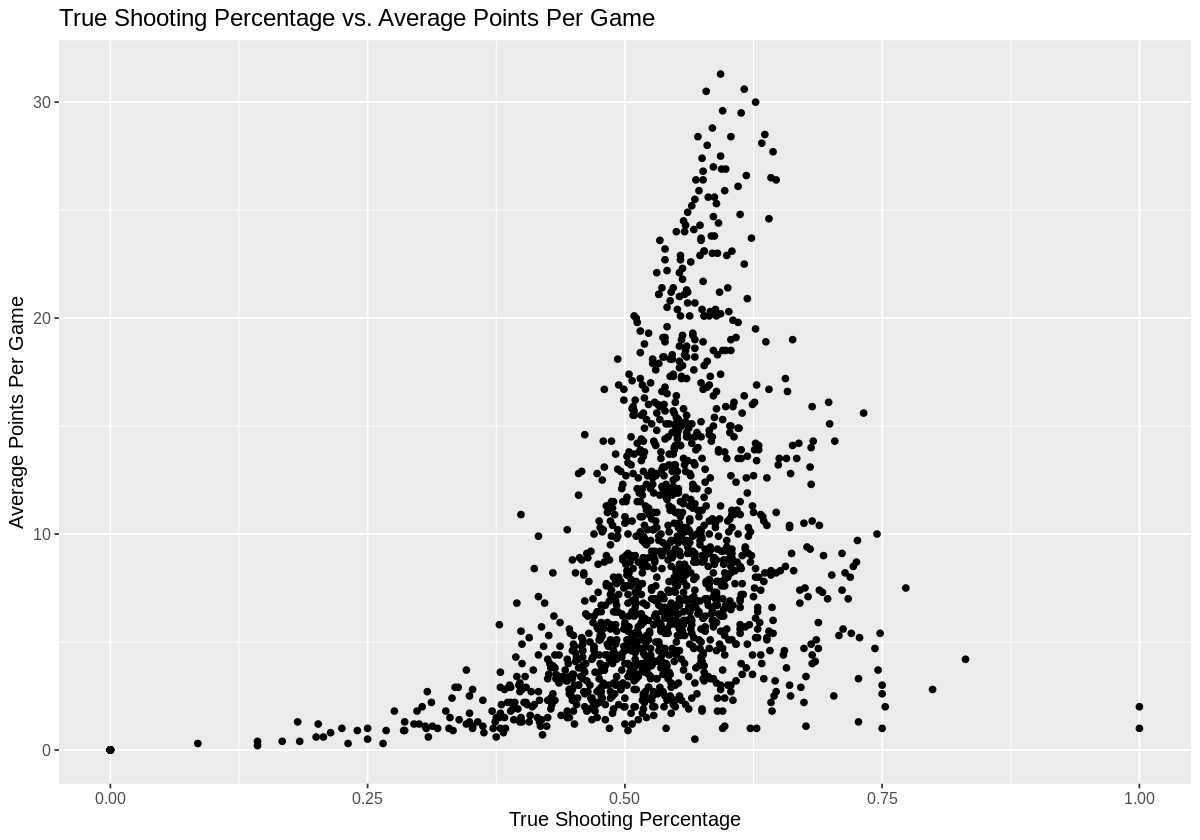

In [86]:
options(repr.plot.width = 10)


nba_plot_nr <- ggplot(nba_training, aes(x = net_rating, y = pts)) +
geom_point() +
labs(x = "Net Performance Rating", y = "Average Points Per Game") +
ggtitle("Net Performance Rating vs. Average Points Per Game") +
theme(text = element_text(size = 12))


nba_plot_number <- ggplot(nba_training, aes(x = draft_number, y = pts)) +
geom_point() +
labs(x = "Draft Number", y = "Average Points Per Game") +
ggtitle("Draft Number vs. Average Points Per Game") +
theme(text = element_text(size = 12))

nba_plot_rebounds <- ggplot(nba_training, aes(x = reb, y = pts)) +
geom_point() +
labs(x = "Rebound", y = "Average Points Per Game") +
ggtitle("Rebound vs. Average Points Per Game") +
theme(text = element_text(size = 12))

nba_plot_assists <- ggplot(nba_training, aes(x = ast, y = pts)) +
geom_point() +
labs(x = "Assist", y = "Average Points Per Game") +
ggtitle("Assist vs. Average Points Per Game") +
theme(text = element_text(size = 12))

nba_plot_usage_pct <- ggplot(nba_training, aes(x = usg_pct, y = pts)) +
geom_point() +
labs(x = "Usage Percentage", y = "Average Points Per Game") +
ggtitle("Usage Percentage vs. Average Points Per Game") +
theme(text = element_text(size = 12))

nba_plot_true_shooting_pct <- ggplot(nba_training, aes(x = ts_pct, y = pts)) +
geom_point() +
labs(x = "True Shooting Percentage", y = "Average Points Per Game") +
ggtitle("True Shooting Percentage vs. Average Points Per Game") +
theme(text = element_text(size = 12))


nba_plot_nr
nba_plot_number
nba_plot_rebounds
nba_plot_assists
nba_plot_usage_pct
nba_plot_true_shooting_pct

As shown in the graphs, younger players and earlier draft position have positive correlation with average points. We expect these two parameters to be good predictors for performance. Basic information about the dataset is presented in the following table, consisting of the means for age, weight, height, draft number, as well as how many data points are contained in the set. 

In [87]:
summarise_nr <- summarise(nba_training, mean_nr = mean(net_rating))
summarise_draft_number <- nba_training |>
summarise(mean_number = mean(as.numeric(draft_number), na.rm = TRUE))
summarise_rebounds <- summarise(nba_training, mean_rebounds = mean(reb))
summarise_assists <- summarise(nba_training, mean_weight = mean(ast))
summarise_usage_pct <- summarise(nba_training, mean_usage = mean(usg_pct))
summarise_true_shooting_pct <- summarise(nba_training, mean_ts = mean(ts_pct))
summarise_nrow <- summarise(nba_training, total_rows = nrow(nba_training))



combined_summary <- bind_cols(summarise_nr, summarise_draft_number, summarise_rebounds, summarise_assists, summarise_usage_pct,
summarise_true_shooting_pct, summarise_nrow)


combined_summary



mean_nr,mean_number,mean_rebounds,mean_weight,mean_usage,mean_ts,total_rows
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
-3.31611,24.57702,3.658344,1.826637,0.1841367,0.5294891,1558


## Data Analysis

To predict the player performance variable, we will be using k-nearest neighbors regression, as the relationships between the predictor variables and our performance variable are not all linear, and the performance variable is numeric.

First, we prepare the recipe by using the (scaled) age, player height, player weight, draft number, and draft round to predict the player's average points.

In [98]:
nba_recipe <- recipe(pts ~ reb + ast + usg_pct + ts_pct + draft_number, data = nba_training) |>
step_scale(all_predictors()) |>
step_center(all_predictors())

nba_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 5



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



Then, we prepare the model. First, we will using tuning to determine the best number of neighbours to use, employing 5-fold cross-validation.

In [99]:
nba_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
set_engine("kknn") |>
set_mode("regression")

nba_vfold <- vfold_cv(nba_training, v = 5, strata = pts)

nba_workflow <- workflow() |>
add_recipe(nba_recipe) |>
add_model(nba_spec)

nba_workflow


══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Finally, we put it all together, using between 1 to 150 neighbours in increments of 5.

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,2.451806,5,0.02475055,Preprocessor1_Model01
6,rmse,standard,1.963280,5,0.02788606,Preprocessor1_Model02
11,rmse,standard,1.974184,5,0.03203982,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
86,rmse,standard,2.498883,5,0.03908438,Preprocessor1_Model18
91,rmse,standard,2.524551,5,0.04083559,Preprocessor1_Model19
96,rmse,standard,2.549792,5,0.04173656,Preprocessor1_Model20


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
6,rmse,standard,1.96328,5,0.02788606,Preprocessor1_Model02


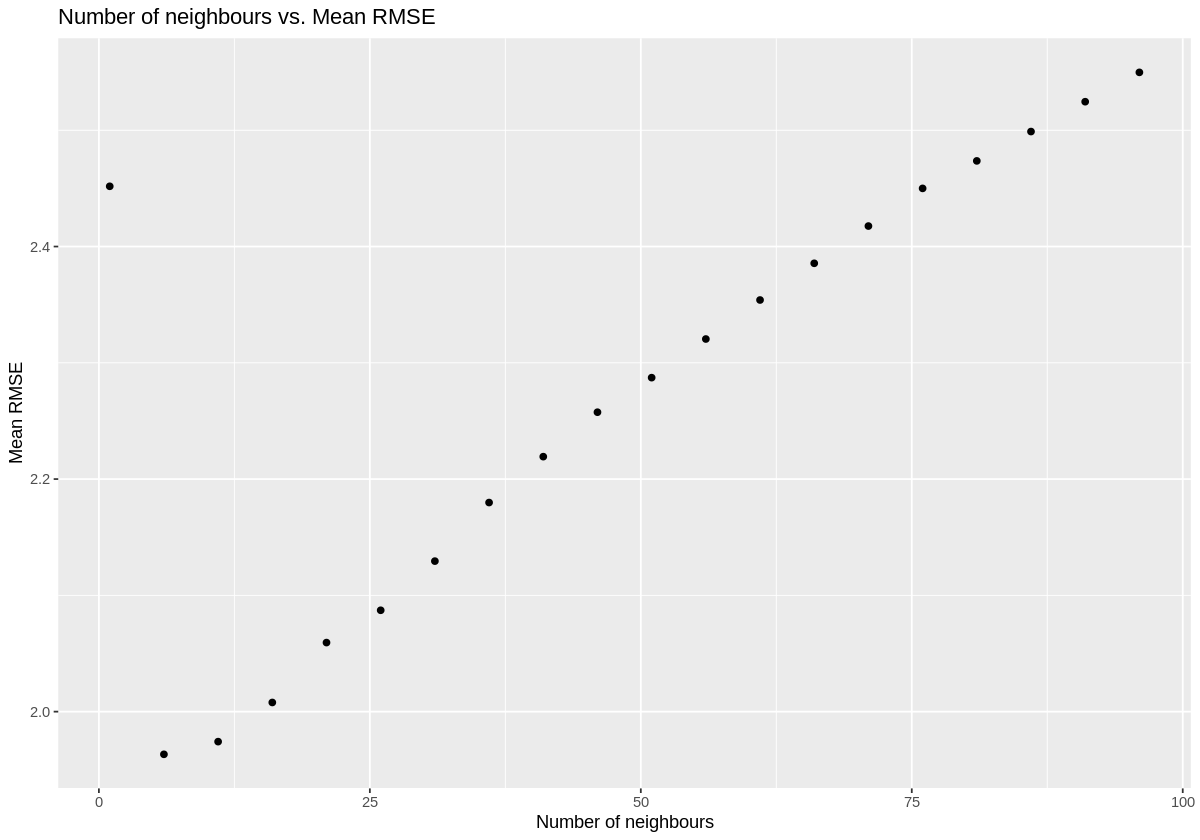

In [100]:
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

nba_results <- nba_workflow |>
  tune_grid(resamples = nba_vfold, grid = k_vals) |>
  collect_metrics() |>
  filter(.metric == "rmse")

nba_results

nba_k_initial <- nba_results |>
  filter(mean == min(mean))
nba_k_initial

nba_k_plot <- ggplot(nba_results, aes(x = neighbors, y = mean)) +
geom_point() +
labs(x = "Number of neighbours", y = "Mean RMSE") +
ggtitle("Number of neighbours vs. Mean RMSE")

nba_k_plot


In [101]:
k_vals_narrow <- tibble(neighbors = seq(from = 5, to = 20, by = 1))

nba_results_2 <- nba_workflow |>
  tune_grid(resamples = nba_vfold, grid = k_vals_narrow) |>
  collect_metrics() |>
  filter(.metric == "rmse")

nba_results_2

nba_smallest <- nba_results_2 |>
  filter(mean == min(mean))
nba_smallest


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
5,rmse,standard,1.973610,5,0.02980653,Preprocessor1_Model01
6,rmse,standard,1.963280,5,0.02788606,Preprocessor1_Model02
7,rmse,standard,1.954001,5,0.03153516,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
18,rmse,standard,2.021880,5,0.02075032,Preprocessor1_Model14
19,rmse,standard,2.030277,5,0.01576108,Preprocessor1_Model15
20,rmse,standard,2.042896,5,0.01516532,Preprocessor1_Model16


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
8,rmse,standard,1.953019,5,0.03111174,Preprocessor1_Model04


Next, we prepare the final model, using the optimal amount of neighbors.

In [102]:
neighbors_val <- nba_smallest |>
pull(neighbors)

nba_tuned_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = neighbors_val) |>
  set_engine("kknn") |>
  set_mode("regression")

nba_fit <- workflow() |>
  add_recipe(nba_recipe) |>
  add_model(nba_tuned_spec) |>
  fit(data = nba_training)

nba_predict <- nba_fit |>
  predict(nba_testing) |>
  bind_cols(nba_testing)

nba_rmse <- nba_predict |>
  metrics(truth = pts, estimate = .pred) |>
  filter(.metric == 'rmse')

nba_predict_select <- nba_predict |>
select(.pred, pts)

nba_predict_select

nba_rmse

#head(nba_players |> arrange(pts, .desc = TRUE))

.pred,pts
<dbl>,<dbl>
2.8875,2.3
5.4625,4.0
3.6375,4.0
⋮,⋮
4.8375,4.6
5.5875,5.7
12.4125,11.3


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1.933981


Due to the multiple variables used in prediction, the visualization for this prediction is difficult to produce. Instead, each variable used in the analysis is presented separately.

!!! Comments here

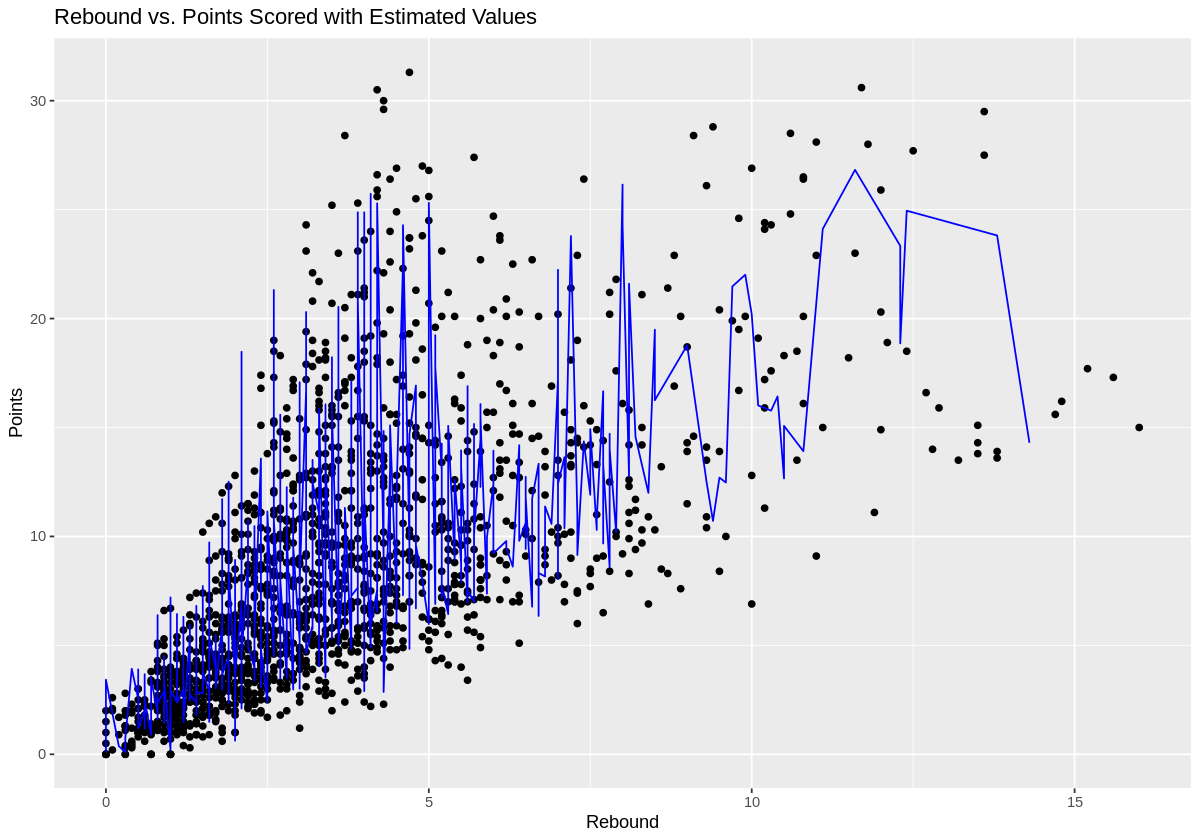

In [104]:
nba_predict_plot_rebound <- ggplot(nba_training, aes(x = reb, y = pts)) +
geom_point() +
geom_line(data = nba_predict, mapping = aes(x = reb, y = .pred), color = 'blue') +
labs(x = "Rebound", y = "Points") +
ggtitle("Rebound vs. Points Scored with Estimated Values")

nba_predict_plot_rebound

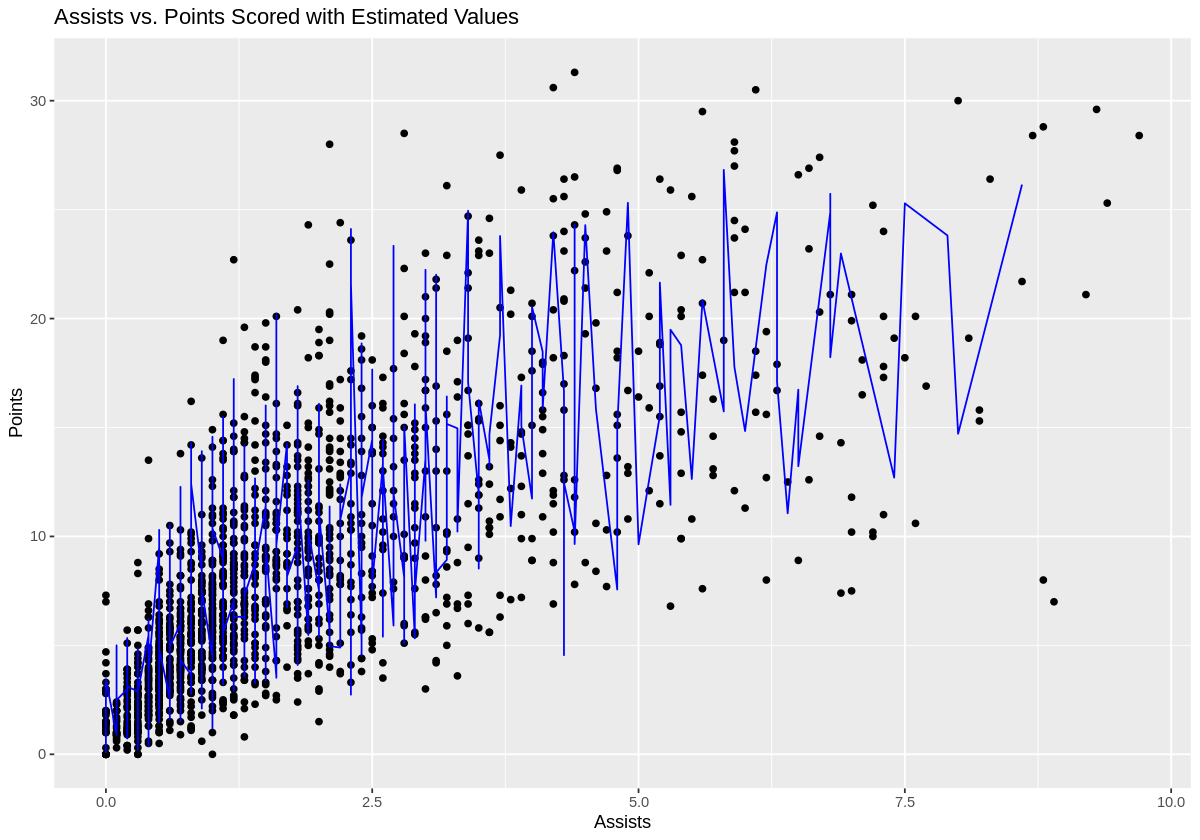

In [105]:
nba_predict_plot_assist <- ggplot(nba_training, aes(x = ast, y = pts)) +
geom_point() +
geom_line(data = nba_predict, mapping = aes(x = ast, y = .pred), color = 'blue') +
labs(x = "Assists", y = "Points") +
ggtitle("Assists vs. Points Scored with Estimated Values")

nba_predict_plot_assist

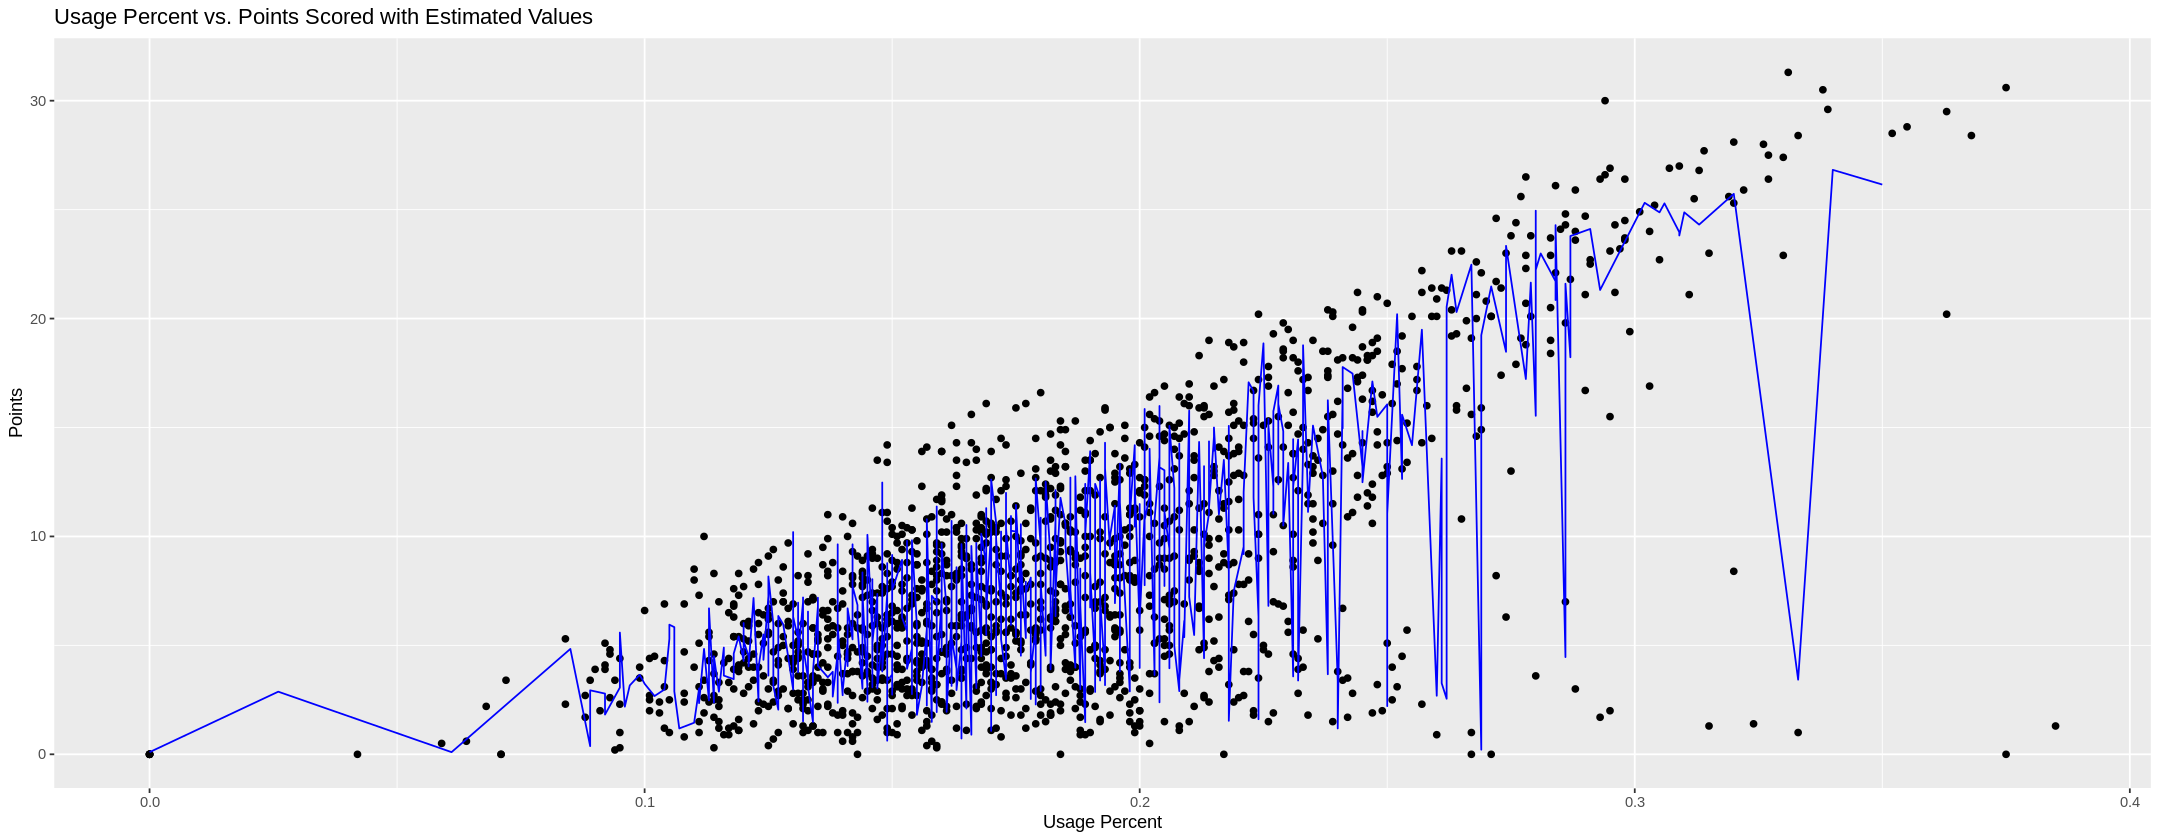

In [106]:
options(repr.plot.width = 18)

nba_predict_plot_usage <- ggplot(nba_training, aes(x = usg_pct, y = pts)) +
geom_point() +
geom_line(data = nba_predict, mapping = aes(x = usg_pct, y = .pred), color = 'blue') +
labs(x = "Usage Percent", y = "Points") +
ggtitle("Usage Percent vs. Points Scored with Estimated Values")

nba_predict_plot_usage

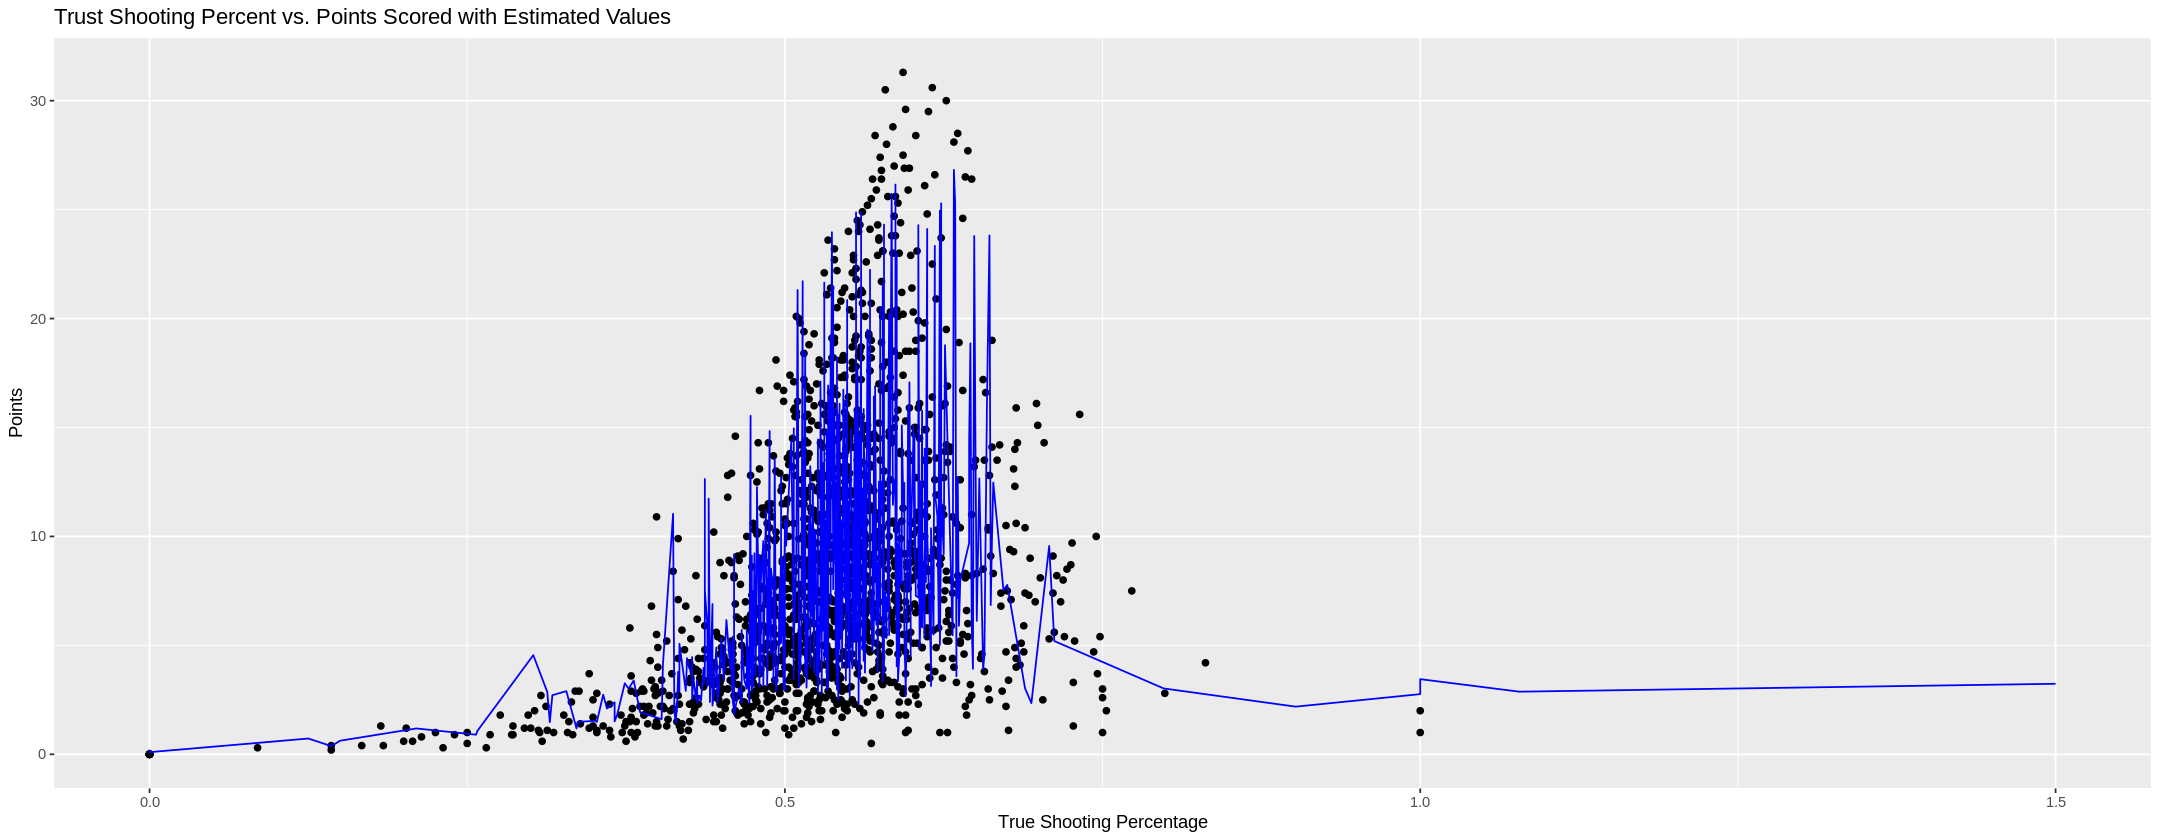

In [109]:
options(repr.plot.width = 18)

nba_predict_plot_shooting <- ggplot(nba_training, aes(x = ts_pct, y = pts)) +
geom_point() +
geom_line(data = nba_predict, mapping = aes(x = ts_pct, y = .pred), color = 'blue') +
labs(x = "True Shooting Percentage", y = "Points") +
ggtitle("Trust Shooting Percent vs. Points Scored with Estimated Values")

nba_predict_plot_shooting

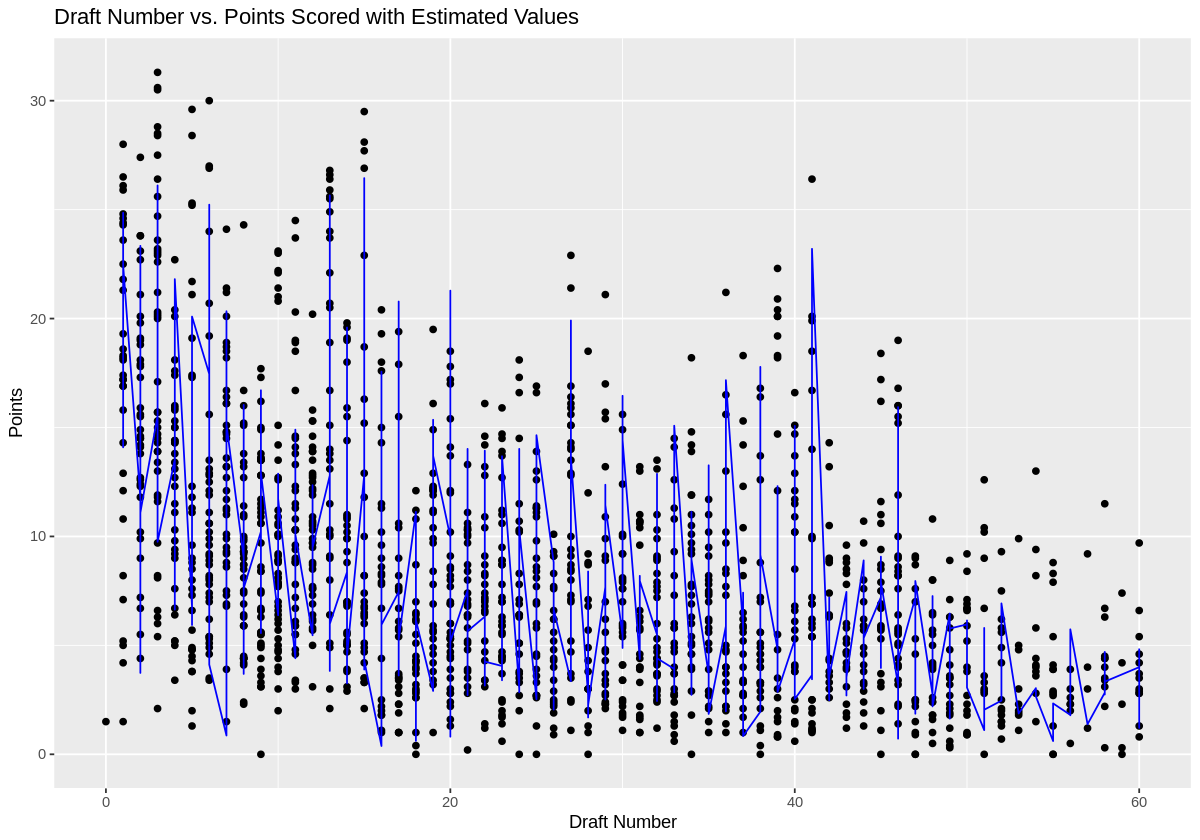

In [97]:
options(repr.plot.width = 10)
nba_predict_plot_dn <- ggplot(nba_training, aes(x = draft_number, y = pts)) +
geom_point() +
geom_line(data = nba_predict, mapping = aes(x = draft_number, y = .pred), color = 'blue') +
labs(x = "Draft Number", y = "Points") +
ggtitle("Draft Number vs. Points Scored with Estimated Values")

nba_predict_plot_dn

# Discussion

* summarize what you found
* discuss whether this is what you expected to find?
* discuss what impact could such findings have?
* discuss what future questions could this lead to?

# References
At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
Make sure to cite the source of your data as well.